In [1]:
%%capture
!pip install roboflow ultralytics
!pip install torch-summary

In [2]:
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from ultralytics import YOLO
from roboflow import Roboflow
import yaml
from pathlib import Path
from torchsummary import summary

# Check if GPU is available
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla T4


In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("roboflow")
rf = Roboflow(api_key=secret_value_0)

# LICENSES PLATE DETECTION
project = rf.workspace("roboflow-universe-projects").project("license-plate-recognition-rxg4e")
dataset = project.version(11).download("yolov11")
print(f"Dataset downloaded to: {dataset.location}")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to License-Plate-Recognition-11 in yolov11:: 100%|██████████| 20262/20262 [00:02<00:00, 7785.66it/s] 


Dataset downloaded to: /kaggle/working/License-Plate-Recognition-11


In [4]:
def explore_dataset(dataset_path):
    """Explore the dataset structure and display statistics"""
    print(" Dataset Structure:")
    print("=" * 50)

    # Walk through dataset directory
    for root, dirs, files in os.walk(dataset_path):
        level = root.replace(dataset_path, '').count(os.sep)
        indent = '  ' * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = '  ' * (level + 1)
        for file in files[:5]:  # Show first 5 files
            print(f"{subindent}{file}")
        if len(files) > 5:
            print(f"{subindent}... and {len(files)-5} more files")

    # Read and display data.yaml
    yaml_path = os.path.join(dataset_path, 'data.yaml')
    if os.path.exists(yaml_path):
        print("\n📄 Dataset Configuration:")
        print("=" * 50)
        with open(yaml_path, 'r') as f:
            config = yaml.safe_load(f)
            print(yaml.dump(config, default_flow_style=False))

    # Count images in each split
    print("\n📊 Dataset Statistics:")
    print("=" * 50)
    splits = ['train', 'valid', 'test']
    total_images = 0

    for split in splits:
        img_dir = os.path.join(dataset_path, split, 'images')
        label_dir = os.path.join(dataset_path, split, 'labels')

        if os.path.exists(img_dir):
            images = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            labels = [f for f in os.listdir(label_dir) if f.lower().endswith('.txt')] if os.path.exists(label_dir) else []

            print(f"{split.capitalize():>8}: {len(images):>6} images, {len(labels):>6} labels")
            total_images += len(images)

    print(f"{'Total':>8}: {total_images:>6} images")
    return yaml_path

# Explore the downloaded dataset
yaml_path = explore_dataset(dataset.location)


 Dataset Structure:
License-Plate-Recognition-11/
  README.roboflow.txt
  README.dataset.txt
  data.yaml
  valid/
    labels/
      Cars334_png_jpg.rf.6ba0704682d9cb4460104ce5c0662e40.txt
      CarLongPlateGen1931_jpg.rf.73b0df8cd098763c9398b47bcc47e654.txt
      xemay1427_jpg.rf.edda3c2e9635764af0ccc62cdc3a1f03.txt
      CarLongPlateGen3540_jpg.rf.0f284c8fa220a18cce72128432ee16e5.txt
      CarLongPlate396_jpg.rf.0dda6811a8fd6e9812fce34eee535196.txt
      ... and 2043 more files
    images/
      xemayBigPlate2_jpg.rf.94629569cb473a1543bd8df91e3881a6.jpg
      CarLongPlate190_jpg.rf.f5a0e75920f451a0c6cb44aa040becb7.jpg
      CarLongPlateGen3540_jpg.rf.0f284c8fa220a18cce72128432ee16e5.jpg
      boderquandoi63_jpg.rf.6f1a7ba17466fa2963587373ced46e0e.jpg
      CarLongPlateGen2807_jpg.rf.4bacaf98a3aac474e9dae710536b1b96.jpg
      ... and 2043 more files
  test/
    labels/
      xemay1230_jpg.rf.ecea4992fd402efdccbb18053bc6a538.txt
      CarLongPlateGen846_jpg.rf.ce0b638a93bafc859fb9649fca

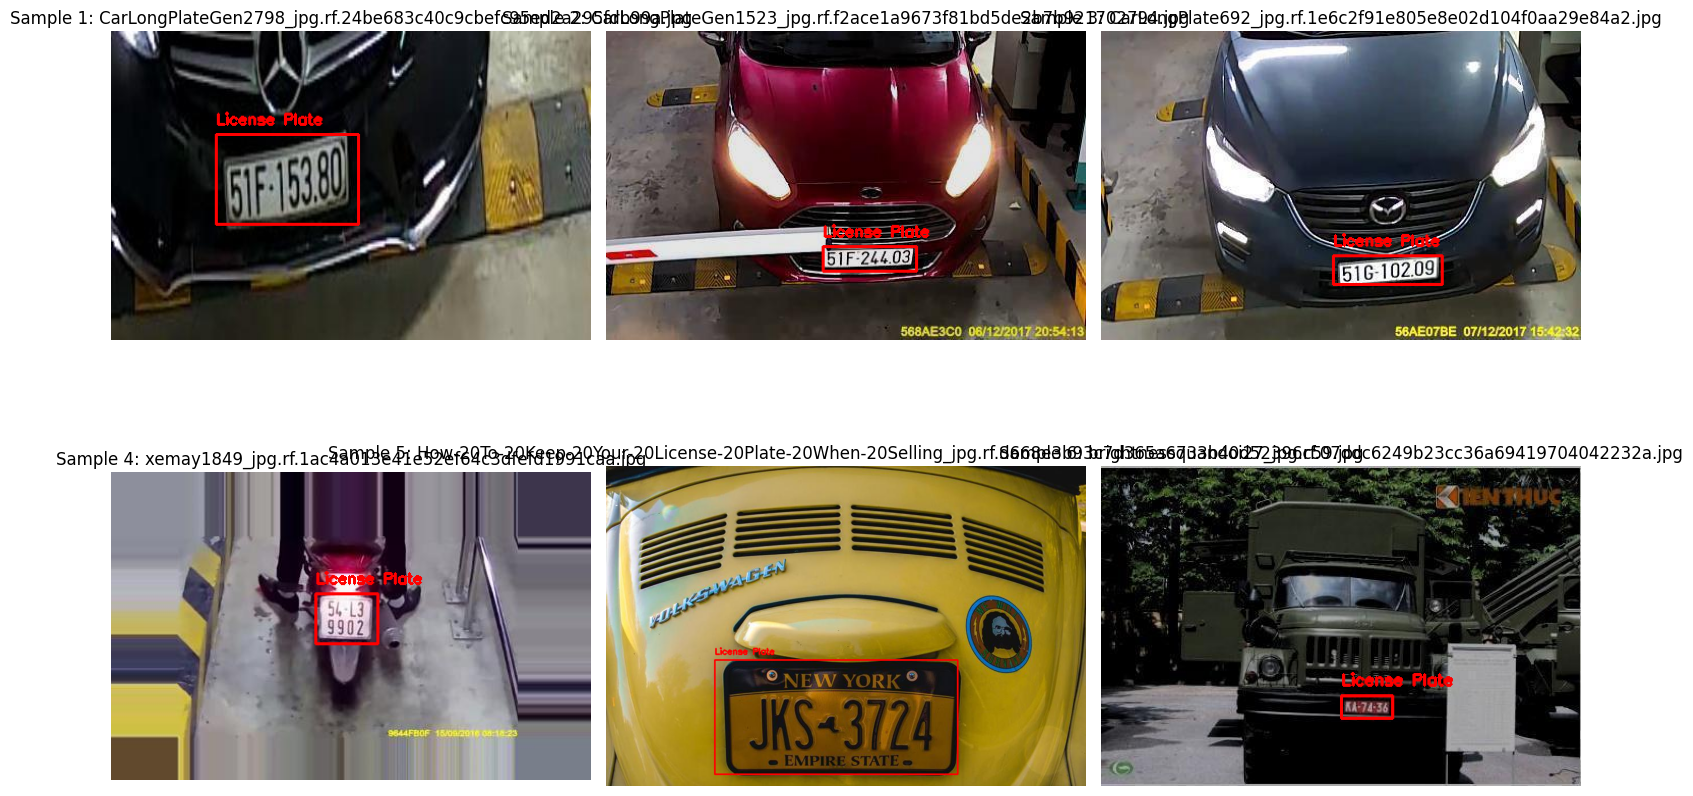

In [5]:
def visualize_samples(dataset_path, num_samples=6):
    """Visualize random samples from the training set"""
    train_img_dir = os.path.join(dataset_path, 'train', 'images')
    train_label_dir = os.path.join(dataset_path, 'train', 'labels')

    if not os.path.exists(train_img_dir):
        print("❌ Training images directory not found!")
        return

    # Get random sample images
    image_files = [f for f in os.listdir(train_img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    sample_files = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)

    # Create subplot
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, img_file in enumerate(sample_files):
        if i >= num_samples:
            break

        # Load image
        img_path = os.path.join(train_img_dir, img_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load corresponding label
        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(train_label_dir, label_file)

        if os.path.exists(label_path):
            # Draw bounding boxes
            h, w = image.shape[:2]
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    class_id, x_center, y_center, width, height = map(float, line.strip().split())

                    # Convert YOLO format to pixel coordinates
                    x1 = int((x_center - width/2) * w)
                    y1 = int((y_center - height/2) * h)
                    x2 = int((x_center + width/2) * w)
                    y2 = int((y_center + height/2) * h)

                    # Draw bounding box
                    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(image, 'License Plate', (x1, y1-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        axes[i].imshow(image)
        axes[i].set_title(f'Sample {i+1}: {img_file}')
        axes[i].axis('off')

    # Hide unused subplots
    for i in range(len(sample_files), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize sample images
visualize_samples(dataset.location)

In [6]:
# Available YOLOv11 models (from smallest to largest)
# model_options
# 'yolo11n': 'Nano - Fastest, lowest accuracy',
# 'yolo11s': 'Small - Good balance of speed and accuracy',
# 'yolo11m': 'Medium - Better accuracy, slower',
# 'yolo11l': 'Large - High accuracy, slower',
# 'yolo11x': 'Extra Large - Highest accuracy, slowest'

MODEL_SIZE = 'yolo11s'

# Initialize YOLOv11 model
model = YOLO(f'{MODEL_SIZE}.pt')

print(f"✅ Model initialized: {MODEL_SIZE}")
# print(f"Model architecture: {model.model}")
summary(model, depth = 5)

100%|██████████| 18.4M/18.4M [00:00<00:00, 97.2MB/s]


✅ Model initialized: yolo11s
Layer (type:depth-idx)                             Param #
├─DetectionModel: 1-1                              --
|    └─Sequential: 2-1                             --
|    |    └─Conv: 3-1                              --
|    |    |    └─Conv2d: 4-1                       (864)
|    |    |    └─BatchNorm2d: 4-2                  (64)
|    |    |    └─SiLU: 4-3                         --
|    |    └─Conv: 3-2                              --
|    |    |    └─Conv2d: 4-4                       (18,432)
|    |    |    └─BatchNorm2d: 4-5                  (128)
|    |    |    └─SiLU: 4-6                         --
|    |    └─C3k2: 3-3                              --
|    |    |    └─Conv: 4-7                         --
|    |    |    |    └─Conv2d: 5-1                  (4,096)
|    |    |    |    └─BatchNorm2d: 5-2             (128)
|    |    |    |    └─SiLU: 5-3                    --
|    |    |    └─Conv: 4-8                         --
|    |    |    |    └─Conv

Layer (type:depth-idx)                             Param #
├─DetectionModel: 1-1                              --
|    └─Sequential: 2-1                             --
|    |    └─Conv: 3-1                              --
|    |    |    └─Conv2d: 4-1                       (864)
|    |    |    └─BatchNorm2d: 4-2                  (64)
|    |    |    └─SiLU: 4-3                         --
|    |    └─Conv: 3-2                              --
|    |    |    └─Conv2d: 4-4                       (18,432)
|    |    |    └─BatchNorm2d: 4-5                  (128)
|    |    |    └─SiLU: 4-6                         --
|    |    └─C3k2: 3-3                              --
|    |    |    └─Conv: 4-7                         --
|    |    |    |    └─Conv2d: 5-1                  (4,096)
|    |    |    |    └─BatchNorm2d: 5-2             (128)
|    |    |    |    └─SiLU: 5-3                    --
|    |    |    └─Conv: 4-8                         --
|    |    |    |    └─Conv2d: 5-4                  (12,

In [7]:
TRAINING_CONFIG = {
    # Dataset
    'data': yaml_path,

    # Training parameters
    'epochs': 100,           # Number of training epochs
    'batch': 16,            # Batch size
    'imgsz': 640,           # Image size for training
    'freeze': 10,

    # Optimization
    'lr0': 0.01,            # Initial learning rate
    'lrf': 0.01,            # Final learning rate factor
    'momentum': 0.9,      # SGD momentum
    'weight_decay': 0.001, # Weight decay

    # Augmentation
    'hsv_h': 0.01,          # Reduced hue variation
    'hsv_s': 0.5,           # Moderate saturation changes
    'hsv_v': 0.3,           # Moderate brightness changes
    'degrees': 5.0,         # Small rotation for realistic angles
    'translate': 0.2,       # Increased translation for position variance
    'scale': 0.8,           # Increased scale variation for distance changes
    'shear': 2.0,           # Small shear for perspective effects
    'perspective': 0.0001,  # Tiny perspective change
    'flipud': 0.0,          # No vertical flip
    'fliplr': 0.5,          # Keep horizontal flip
    'mosaic': 0.8,          # Reduced mosaic probability for cleaner training

    # Validation and saving
    'val': True,            # Validate during training
    'save': True,           # Save model checkpoints
    'save_period': 10,      # Save checkpoint every N epochs
    'cache': 'ram',         # Cache images for faster training

    # Hardware
    'device': 0 if torch.cuda.is_available() else 'cpu',
    'workers': 2,           # Number of worker threads

    # Experiment tracking
    'name': 'license_plate_yolo11',
    'project': 'runs/detect',
    'exist_ok': True,

    # Early stopping
    'patience': 10,         # Epochs to wait for improvement

    # Other
    'verbose': True,        # Verbose output
    'seed': 42,             # Random seed for reproducibility
}


In [8]:
print("\n🚀 Starting YOLOv11 Training...")
print("=" * 50)
print(f"Model: {MODEL_SIZE}")
print(f"Dataset: License Plate Recognition")
print(f"Epochs: {TRAINING_CONFIG['epochs']}")
print(f"Batch Size: {TRAINING_CONFIG['batch']}")
print(f"Image Size: {TRAINING_CONFIG['imgsz']}")
print("=" * 50)

# Start training
results = model.train(**TRAINING_CONFIG)

print("\n✅ Training completed!")


🚀 Starting YOLOv11 Training...
Model: yolo11s
Dataset: License Plate Recognition
Epochs: 100
Batch Size: 16
Image Size: 640
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/License-Plate-Recognition-11/data.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.01, hsv_s=0.5, hsv_v=0.3, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.9, mosaic=0.8, multi_scale=False, name=license_plat

100%|██████████| 755k/755k [00:00<00:00, 18.0MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 42.4MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 601.0±245.4 MB/s, size: 32.3 KB)


train: Scanning /kaggle/working/License-Plate-Recognition-11/train/labels... 7057 images, 5 backgrounds, 0 corrupt: 100%|██████████| 7057/7057 [00:04<00:00, 1508.28it/s]


train: New cache created: /kaggle/working/License-Plate-Recognition-11/train/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (5.3GB RAM): 100%|██████████| 7057/7057 [00:11<00:00, 606.94it/s] 


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 645.2±355.0 MB/s, size: 46.3 KB)


val: Scanning /kaggle/working/License-Plate-Recognition-11/valid/labels... 2048 images, 3 backgrounds, 0 corrupt: 100%|██████████| 2048/2048 [00:01<00:00, 1432.79it/s]

val: New cache created: /kaggle/working/License-Plate-Recognition-11/valid/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (1.5GB RAM): 100%|██████████| 2048/2048 [00:03<00:00, 670.25it/s] 


Plotting labels to runs/detect/license_plate_yolo11/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.9' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.001), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/license_plate_yolo11
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       2.1G      1.302      1.074      1.154          2        640: 100%|██████████| 442/442 [01:24<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:13<00:00,  4.68it/s]

                   all       2048       2195      0.974      0.932      0.957      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.64G      1.239     0.7055      1.098          2        640: 100%|██████████| 442/442 [01:24<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  4.96it/s]

                   all       2048       2195      0.967      0.902      0.952      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.66G       1.24     0.7277      1.108          1        640: 100%|██████████| 442/442 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.02it/s]

                   all       2048       2195      0.966      0.919      0.957      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.68G      1.237     0.7048      1.135          1        640: 100%|██████████| 442/442 [01:22<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.02it/s]

                   all       2048       2195      0.963      0.927       0.96       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       3.7G      1.216     0.6762      1.124          1        640: 100%|██████████| 442/442 [01:22<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.06it/s]

                   all       2048       2195      0.974      0.938      0.968      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.72G      1.191     0.6431      1.107          0        640: 100%|██████████| 442/442 [01:22<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.09it/s]

                   all       2048       2195      0.975      0.934      0.973      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.75G      1.181     0.6246      1.111          4        640: 100%|██████████| 442/442 [01:22<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.05it/s]

                   all       2048       2195       0.98       0.94      0.969      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.77G      1.161     0.6096      1.105          4        640: 100%|██████████| 442/442 [01:22<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.05it/s]

                   all       2048       2195      0.978      0.938      0.971       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.79G      1.144     0.5912       1.09          1        640: 100%|██████████| 442/442 [01:22<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.05it/s]

                   all       2048       2195      0.979      0.943      0.971      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.81G      1.146     0.5885      1.097          1        640: 100%|██████████| 442/442 [01:22<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.09it/s]

                   all       2048       2195      0.973      0.947      0.975      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.83G      1.125     0.5734       1.08          1        640: 100%|██████████| 442/442 [01:22<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.09it/s]

                   all       2048       2195      0.976      0.943      0.973       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.85G      1.119     0.5642      1.085          1        640: 100%|██████████| 442/442 [01:22<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.08it/s]

                   all       2048       2195       0.98      0.947      0.974      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.88G       1.12     0.5621      1.084          1        640: 100%|██████████| 442/442 [01:22<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.07it/s]

                   all       2048       2195      0.984      0.949      0.975      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       3.9G      1.119     0.5593      1.078          1        640: 100%|██████████| 442/442 [01:22<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.10it/s]

                   all       2048       2195      0.983      0.945      0.975      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.92G      1.106     0.5475      1.069          2        640: 100%|██████████| 442/442 [01:22<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.11it/s]

                   all       2048       2195      0.981       0.95      0.977       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.94G      1.097     0.5341      1.064          1        640: 100%|██████████| 442/442 [01:22<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.10it/s]

                   all       2048       2195      0.977      0.952      0.979      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.96G       1.09     0.5275       1.06          1        640: 100%|██████████| 442/442 [01:21<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.06it/s]

                   all       2048       2195      0.984      0.951      0.977      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.98G      1.093     0.5279      1.065          1        640: 100%|██████████| 442/442 [01:22<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.08it/s]

                   all       2048       2195      0.982      0.947      0.974      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         4G      1.091     0.5277      1.063          1        640: 100%|██████████| 442/442 [01:22<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.07it/s]

                   all       2048       2195      0.978       0.95      0.975      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.03G      1.077     0.5198      1.059          1        640: 100%|██████████| 442/442 [01:22<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.10it/s]

                   all       2048       2195      0.986       0.95      0.976      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.05G       1.07      0.507       1.05          4        640: 100%|██████████| 442/442 [01:22<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.07it/s]

                   all       2048       2195       0.98      0.955      0.977      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.07G      1.067     0.5092       1.05          1        640: 100%|██████████| 442/442 [01:22<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.07it/s]

                   all       2048       2195      0.987      0.953      0.978      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.09G      1.058     0.4985       1.05          1        640: 100%|██████████| 442/442 [01:22<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.09it/s]

                   all       2048       2195      0.983      0.951      0.978      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.11G      1.059     0.4982      1.047          2        640: 100%|██████████| 442/442 [01:22<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.09it/s]

                   all       2048       2195      0.985      0.949      0.974      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.13G      1.048     0.4977      1.041          1        640: 100%|██████████| 442/442 [01:22<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.08it/s]

                   all       2048       2195      0.983      0.956      0.975      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.16G      1.056     0.5004      1.046          1        640: 100%|██████████| 442/442 [01:22<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.08it/s]

                   all       2048       2195      0.986       0.95      0.974      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.18G      1.047     0.4919       1.04          1        640: 100%|██████████| 442/442 [01:22<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.09it/s]

                   all       2048       2195      0.984      0.949      0.977      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       4.2G      1.051     0.4889       1.04          2        640: 100%|██████████| 442/442 [01:22<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.06it/s]

                   all       2048       2195      0.984      0.953      0.977      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.22G      1.043      0.484      1.035          1        640: 100%|██████████| 442/442 [01:22<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.06it/s]

                   all       2048       2195      0.978      0.958       0.98       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.24G      1.042     0.4841      1.037          4        640: 100%|██████████| 442/442 [01:22<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.08it/s]

                   all       2048       2195      0.985      0.954       0.98      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.26G      1.045     0.4805      1.039          1        640: 100%|██████████| 442/442 [01:22<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.09it/s]

                   all       2048       2195       0.98      0.953      0.977      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.29G      1.027     0.4788      1.029          1        640: 100%|██████████| 442/442 [01:22<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.13it/s]

                   all       2048       2195      0.985      0.951      0.979      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.31G      1.036     0.4793      1.032          4        640: 100%|██████████| 442/442 [01:22<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.11it/s]

                   all       2048       2195      0.983      0.955      0.979      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.33G      1.026     0.4707      1.033          2        640: 100%|██████████| 442/442 [01:22<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.08it/s]

                   all       2048       2195      0.982      0.955      0.979      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.35G      1.018      0.466      1.021          1        640: 100%|██████████| 442/442 [01:22<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.11it/s]

                   all       2048       2195      0.985      0.952       0.98      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.37G      1.027      0.468      1.032          1        640: 100%|██████████| 442/442 [01:22<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.09it/s]

                   all       2048       2195      0.983      0.953      0.979      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.39G       1.02     0.4664      1.024          4        640: 100%|██████████| 442/442 [01:22<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.11it/s]

                   all       2048       2195      0.987      0.955      0.978      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.41G     0.9999     0.4611      1.022          1        640: 100%|██████████| 442/442 [01:22<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.08it/s]

                   all       2048       2195      0.985      0.951      0.978        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.44G      1.011     0.4647      1.024          2        640: 100%|██████████| 442/442 [01:22<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.13it/s]

                   all       2048       2195      0.985      0.953      0.979      0.706
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 29, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



39 epochs completed in 1.035 hours.
Optimizer stripped from runs/detect/license_plate_yolo11/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/license_plate_yolo11/weights/best.pt, 19.2MB

Validating runs/detect/license_plate_yolo11/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:13<00:00,  4.60it/s]
invalid value encountered in less
invalid value encountered in less


                   all       2048       2195      0.978      0.958      0.979      0.709
Speed: 0.1ms preprocess, 3.4ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/license_plate_yolo11

✅ Training completed!


In [9]:
print("\n📊 Evaluating Model Performance...")

# Validate the model
validation_results = model.val()

print("Validation Results:")
print("=" * 50)
print(f"mAP50: {validation_results.box.map50:.4f}")
print(f"mAP50-95: {validation_results.box.map:.4f}")
print(f"Precision: {validation_results.box.mp:.4f}")
print(f"Recall: {validation_results.box.mr:.4f}")


📊 Evaluating Model Performance...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 793.3±491.6 MB/s, size: 30.6 KB)


val: Scanning /kaggle/working/License-Plate-Recognition-11/valid/labels.cache... 2048 images, 3 backgrounds, 0 corrupt: 100%|██████████| 2048/2048 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (1.5GB RAM): 100%|██████████| 2048/2048 [00:03<00:00, 649.87it/s] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:20<00:00,  6.35it/s]
invalid value encountered in less
invalid value encountered in less


                   all       2048       2195      0.978      0.957      0.979      0.709
Speed: 0.2ms preprocess, 6.9ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/license_plate_yolo11
Validation Results:
mAP50: 0.9792
mAP50-95: 0.7091
Precision: 0.9776
Recall: 0.9572


📈 Training Results:


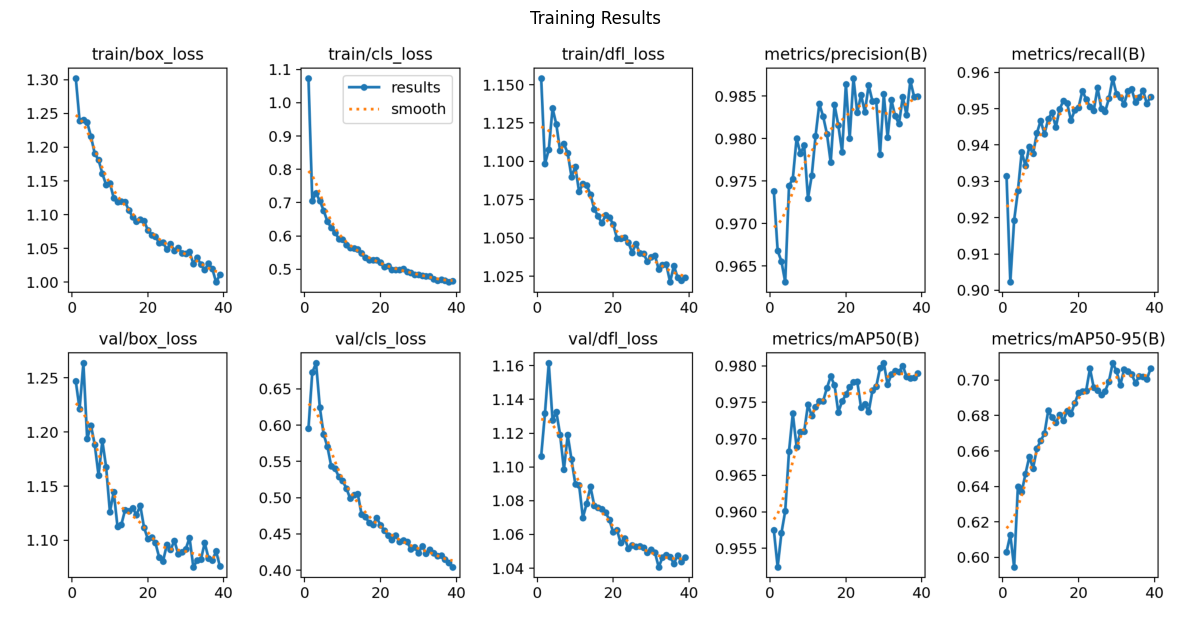

📊 Confusion Matrix:


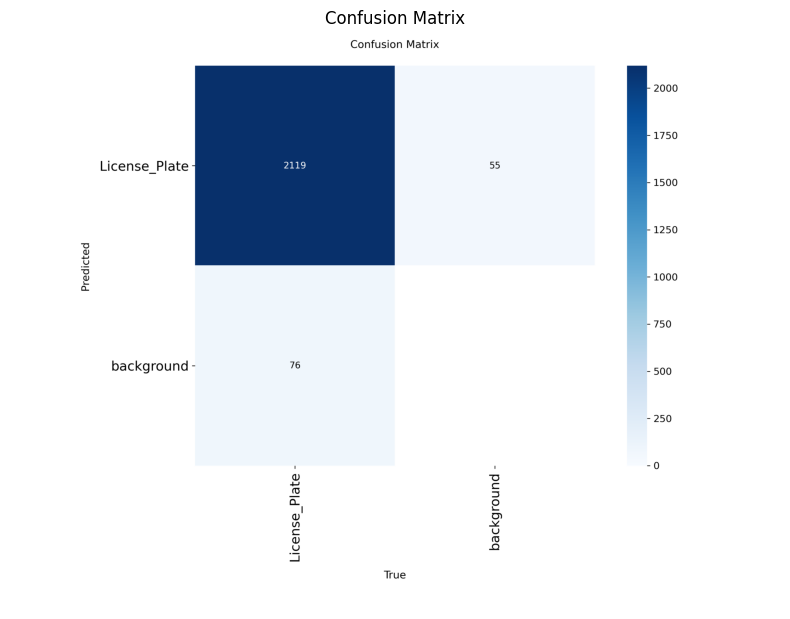

In [10]:
def plot_training_results(results_dir):
    """Plot training results from the results directory"""
    results_path = Path(results_dir)

    # Check if results.png exists
    results_img = results_path / 'results.png'
    if results_img.exists():
        print("📈 Training Results:")
        img = plt.imread(str(results_img))
        plt.figure(figsize=(12, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title('Training Results')
        plt.tight_layout()
        plt.show()
    else:
        print("❌ Results plot not found!")

    # Show confusion matrix if available
    confusion_matrix = results_path / 'confusion_matrix.png'
    if confusion_matrix.exists():
        print("📊 Confusion Matrix:")
        img = plt.imread(str(confusion_matrix))
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()

# Plot training results
results_dir = f"runs/detect/{TRAINING_CONFIG['name']}"
plot_training_results(results_dir)

In [11]:
export_formats = {
    'pytorch': 'pt',
    'onnx': 'onnx',
    'tensorrt': 'engine',
    'coreml': 'mlmodel',
    'tflite': 'tflite'
}

# Export to ONNX (most common for deployment)
print("\n🔄 Exporting to ONNX format...")
onnx_model = model.export(format='onnx', imgsz=640)


🔄 Exporting to ONNX format...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'runs/detect/license_plate_yolo11/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (18.3 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.59', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 11.3s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.61...
ONNX: export success ✅ 14.8s, saved as 'runs/detect/license_plate_yolo11/weights/best.onnx' (36.1 MB)

Export complete (15.4s)
Results saved to /kaggle/working/runs/detect/license_plate_yolo11/weights
Predict:         yolo predict t